<a href="https://colab.research.google.com/github/AedinMcCann/Thesis/blob/main/FINAL_AAPL_Rolling_Linear_submissions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages

In [1]:
pip install yfinance

In [2]:
pip install yahoofinancials

In [3]:
pip install pyfinance

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from yahoofinancials import YahooFinancials
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
import pyfinance
from pyfinance import ols
import pandas_datareader as pdr
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data

In [5]:
# Get stock data
start='2020-01-01'
end='2021-01-02'
df = yf.download(tickers = "AAPL",start=start,end=end,interval = "1d")
df.reset_index(drop=False, inplace=True)

nan_value = float("NaN")
df.replace("", nan_value, inplace=True)
df.tail()
df['Next_close'] = df['Close'].shift(-1)
df.tail()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume,Next_close
248,2020-12-24,131.320007,133.460007,131.100006,131.970001,131.549637,54930100,136.690002
249,2020-12-28,133.990005,137.339996,133.509995,136.690002,136.254608,124486200,134.869995
250,2020-12-29,138.050003,138.789993,134.339996,134.869995,134.440399,121047300,133.720001
251,2020-12-30,135.580002,135.990005,133.399994,133.720001,133.294067,96452100,132.690002
252,2020-12-31,134.080002,134.740005,131.720001,132.690002,132.267349,99116600,NaN


In [6]:
# Add in some technical indicators
# Simple moving average (SMA)
# 3 day period
Close = df[['Close']]
df['SMA'] = df.Close.rolling(3, min_periods=1).mean()

# Exponential moving average (EMA)
df['EMA'] = df.Close.ewm(alpha=0.1, adjust=False).mean()

In [7]:
# On Balance Volume
# Measures cumulative buying and selling pressure by adding the volume on "up" days and subtracting volume on "down" days. 
df['obv'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
df = df.set_index('Date')
df

,Open,High,Low,Close,Adj Close,Volume,Next_close,SMA,EMA,obv
Date,,,,,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,74.207466,135480400,74.357498,75.087502,75.087502,0.000000e+00
2020-01-03,74.287498,75.144997,74.125000,74.357498,73.486023,146322800,74.949997,74.722500,75.014501,-1.463228e+08
2020-01-06,73.447502,74.989998,73.187500,74.949997,74.071579,118387200,74.597504,74.798332,75.008051,-2.793560e+07
2020-01-07,74.959999,75.224998,74.370003,74.597504,73.723213,108872000,75.797501,74.635000,74.966996,-1.368076e+08
2020-01-08,74.290001,76.110001,74.290001,75.797501,74.909149,132079200,77.407501,75.115000,75.050047,-4.728400e+06
...,...,...,...,...,...,...,...,...,...,...
2020-12-24,131.320007,133.460007,131.100006,131.970001,131.549637,54930100,136.690002,131.603338,125.800173,1.434908e+09
2020-12-28,133.990005,137.339996,133.509995,136.690002,136.254608,124486200,134.869995,133.206670,126.889156,1.559395e+09
2020-12-29,138.050003,138.789993,134.339996,134.869995,134.440399,121047300,133.720001,134.510000,127.687240,1.438347e+09


In [8]:
df = df[['Next_close', 'Close','Volume','Open','High','Low', "SMA", 'EMA', 'obv']]

In [9]:
dataset = df.values
scaler = MinMaxScaler()
# transform data
dataset = scaler.fit_transform(dataset)

X = dataset[:-1,1:]
y = dataset[:-1, 0]
x = pd.DataFrame(X)
y = pd.DataFrame(y)

In [10]:
rolling = ols.PandasRollingOLS(y=y, x=X, window=20)
y_pred = rolling.predicted
y_pred = pd.DataFrame(y_pred)
y_pred

predicted
end subperiod           
19  0           0.249954
    1           0.247388
    2           0.239695
    3           0.238421
    4           0.245308
...                  ...
251 247         0.929040
    248         0.966920
    249         0.973193
    250         0.969734
    251         0.976738

[4660 rows x 1 columns]

In [11]:
y_pred = y_pred.reset_index()
counts= y_pred['subperiod'].value_counts()
y_pred = y_pred.groupby('subperiod').sum('predicted')
y_pred['predicted'] = y_pred['predicted']/counts
y_pred = y_pred.reset_index()
y_pred

,subperiod,end,predicted
0,0,19,0.249954
1,1,39,0.250178
2,2,60,0.245344
3,3,82,0.245873
4,4,105,0.258440
...,...,...,...
247,247,1245,0.935555
248,248,998,0.975041
249,249,750,0.976825
250,250,501,0.973283


In [12]:
df_y = y.reset_index()
df_y = df_y.rename(columns={'index':'period', 0:'actual'})
df_y

,period,actual
0,0,0.226620
1,1,0.233971
2,2,0.229598
3,3,0.244487
4,4,0.264462
...,...,...
247,247,0.941437
248,248,1.000000
249,249,0.977419
250,250,0.963150


In [13]:
linear = df_y.join(y_pred, how='outer')
linear['difference'] = linear['actual'] - linear['predicted']
linear = linear.drop(['period','subperiod','end'], axis=1)
linear['sq_er'] = linear['difference']*linear['difference']
linear['AAPL_RMSE_LIN'] = np.sqrt(linear['sq_er'])
linear

,actual,predicted,difference,sq_er,AAPL_RMSE_LIN
0,0.226620,0.249954,-0.023335,5.445027e-04,0.023335
1,0.233971,0.250178,-0.016206,2.626430e-04,0.016206
2,0.229598,0.245344,-0.015746,2.479435e-04,0.015746
3,0.244487,0.245873,-0.001386,1.921941e-06,0.001386
4,0.264462,0.258440,0.006023,3.627077e-05,0.006023
...,...,...,...,...,...
247,0.941437,0.935555,0.005882,3.460191e-05,0.005882
248,1.000000,0.975041,0.024959,6.229660e-04,0.024959
249,0.977419,0.976825,0.000593,3.518331e-07,0.000593
250,0.963150,0.973283,-0.010133,1.026693e-04,0.010133


In [14]:
MSE = linear['sq_er'].sum()/len(linear)
import math 
RMSE = math.sqrt(MSE)
RMSE

0.019189058887188276

## With sentiment

In [15]:
sent = pd.read_excel('AAPL_sentiment_submissions.xlsx')
sent = sent.rename(columns={'date':'Date'})
sent['Date'] = pd.to_datetime(sent['Date'])
df = pd.merge(df, sent, on = 'Date', how = 'left')
#df = df.fillna(0)

df.describe()

,Next_close,Close,Volume,Open,High,Low,SMA,EMA,obv,Unnamed: 0,compound,Count,average
count,252.000000,253.000000,2.530000e+02,253.000000,253.000000,253.000000,253.000000,253.000000,2.530000e+02,238.000000,238.000000,238.000000,238.000000
mean,95.427470,95.347075,1.575646e+08,95.267668,96.661769,93.912796,95.117559,93.438827,-1.852572e+08,162.873950,1.369671,7.243697,0.215569
std,21.815621,21.809814,6.983072e+07,22.011907,22.094637,21.579913,21.653133,20.484365,1.355486e+09,94.458309,2.419022,8.547674,0.374890
min,56.092499,56.092499,4.669130e+07,57.020000,57.125000,53.152500,58.199167,63.574963,-2.837433e+09,1.000000,-4.691100,1.000000,-0.999000
25%,77.401876,77.385002,1.108432e+08,77.025002,78.167503,76.220001,77.627497,75.868229,-1.337033e+09,81.750000,-0.006975,2.000000,-0.002175
50%,92.123749,91.632500,1.380234e+08,91.279999,92.970001,90.910004,91.084997,88.022340,2.525080e+08,161.500000,0.972850,4.000000,0.226325
75%,115.764999,115.750000,1.875728e+08,115.982498,117.279999,114.129997,115.453331,115.672829,1.093211e+09,243.750000,2.122375,8.000000,0.435896
max,136.690002,136.690002,4.265100e+08,138.050003,138.789993,134.339996,135.093333,128.730465,1.630187e+09,329.000000,18.223700,53.000000,0.999000


In [16]:
df = df[['Next_close', 'Close','Volume','Open','High','Low', "SMA", 'EMA', 'obv', 'average']]

dataset = df.values

scaler = MinMaxScaler()
# transform data
dataset = scaler.fit_transform(dataset)

X = dataset[:-1,1:]
x = pd.DataFrame(X)
rolling = ols.PandasRollingOLS(y=y, x=X, window=20)
y_pred_sent = rolling.predicted
y_pred_sent = pd.DataFrame(y_pred_sent)
y_pred_sent = y_pred_sent.reset_index()
y_pred_sent = y_pred_sent.drop(['end'], axis=1)
y_pred_sent

,subperiod,predicted
0,0,0.249220
1,1,0.248470
2,2,0.235552
3,3,0.242200
4,4,0.245624
...,...,...
4655,247,0.929096
4656,248,0.970004
4657,249,0.983321
4658,250,0.964257


In [17]:
y_pred_sent = y_pred_sent.reset_index()
counts= y_pred_sent['subperiod'].value_counts()
y_pred_sent = y_pred_sent.groupby('subperiod').sum('predicted')
y_pred_sent['predicted_sent'] = y_pred_sent['predicted']/counts

In [18]:
linear_sent = df_y.join(y_pred_sent, how='outer')
linear_sent = linear_sent.rename(columns = {0:'actual'})
linear_sent

,period,actual,index,predicted,predicted_sent
0,0,0.226620,0,0.249220,0.249220
1,1,0.233971,21,0.502930,0.251465
2,2,0.229598,63,0.719769,0.239923
3,3,0.244487,126,0.992312,0.248078
4,4,0.264462,210,1.293256,0.258651
...,...,...,...,...,...
247,247,0.941437,23085,4.673481,0.934696
248,248,1.000000,18510,3.902979,0.975745
249,249,0.977419,13914,2.946901,0.982300
250,250,0.963150,9297,1.937640,0.968820


In [20]:
linear_sent['difference_sent'] = linear_sent['actual'] - linear_sent['predicted_sent']
linear_sent = linear_sent.drop(['predicted'], axis=1)
linear_sent['sq_er_sent'] = linear_sent['difference_sent']*linear_sent['difference_sent']
linear_sent['AAPL_RMSE_LIN_SENTIMENT'] = np.sqrt(linear_sent['sq_er_sent'])
linear_sent

,period,actual,index,predicted_sent,difference_sent,sq_er_sent,AAPL_RMSE_LIN_SENTIMENT
0,0,0.226620,0,0.249220,-0.022600,0.000511,0.022600
1,1,0.233971,21,0.251465,-0.017494,0.000306,0.017494
2,2,0.229598,63,0.239923,-0.010325,0.000107,0.010325
3,3,0.244487,126,0.248078,-0.003591,0.000013,0.003591
4,4,0.264462,210,0.258651,0.005811,0.000034,0.005811
...,...,...,...,...,...,...,...
247,247,0.941437,23085,0.934696,0.006741,0.000045,0.006741
248,248,1.000000,18510,0.975745,0.024255,0.000588,0.024255
249,249,0.977419,13914,0.982300,-0.004882,0.000024,0.004882
250,250,0.963150,9297,0.968820,-0.005670,0.000032,0.005670


In [21]:
MSE_sent = linear_sent['sq_er_sent'].sum()/len(linear_sent)
RMSE_sent = math.sqrt(MSE_sent)
RMSE_sent

0.2771425375299746

In [22]:
AAPL_linear = pd.merge(linear, linear_sent, on = 'actual')
AAPL_linear

,actual,predicted,difference,sq_er,AAPL_RMSE_LIN,period,index,predicted_sent,difference_sent,sq_er_sent,AAPL_RMSE_LIN_SENTIMENT
0,0.226620,0.249954,-0.023335,5.445027e-04,0.023335,0,0,0.249220,-0.022600,0.000511,0.022600
1,0.233971,0.250178,-0.016206,2.626430e-04,0.016206,1,21,0.251465,-0.017494,0.000306,0.017494
2,0.229598,0.245344,-0.015746,2.479435e-04,0.015746,2,63,0.239923,-0.010325,0.000107,0.010325
3,0.244487,0.245873,-0.001386,1.921941e-06,0.001386,3,126,0.248078,-0.003591,0.000013,0.003591
4,0.264462,0.258440,0.006023,3.627077e-05,0.006023,4,210,0.258651,0.005811,0.000034,0.005811
...,...,...,...,...,...,...,...,...,...,...,...
253,0.941437,0.935555,0.005882,3.460191e-05,0.005882,247,23085,0.934696,0.006741,0.000045,0.006741
254,1.000000,0.975041,0.024959,6.229660e-04,0.024959,248,18510,0.975745,0.024255,0.000588,0.024255
255,0.977419,0.976825,0.000593,3.518331e-07,0.000593,249,13914,0.982300,-0.004882,0.000024,0.004882
256,0.963150,0.973283,-0.010133,1.026693e-04,0.010133,250,9297,0.968820,-0.005670,0.000032,0.005670


In [23]:
AAPL_linear.describe()

,actual,predicted,difference,sq_er,AAPL_RMSE_LIN,period,index,predicted_sent,difference_sent,sq_er_sent,AAPL_RMSE_LIN_SENTIMENT
count,258.000000,258.000000,258.000000,2.580000e+02,258.000000,258.000000,258.000000,258.000000,258.000000,2.580000e+02,258.000000
mean,0.488651,0.488949,-0.000298,3.619167e-04,0.013394,125.806202,43081.798450,0.314570,0.174082,7.687275e-02,0.180875
std,0.269631,0.268700,0.019059,8.347133e-04,0.013536,73.071052,26528.785031,0.308384,0.216216,1.377629e-01,0.210544
min,0.000000,0.028999,-0.057719,6.942216e-11,0.000008,0.000000,0.000000,0.000000,-0.050314,3.457527e-08,0.000186
25%,0.266168,0.270284,-0.009150,1.951330e-05,0.004417,63.250000,20090.000000,0.010896,0.001951,9.564934e-05,0.009780
50%,0.438336,0.443778,0.000351,8.352776e-05,0.009139,125.000000,43390.000000,0.258724,0.056273,3.169496e-03,0.056273
75%,0.740749,0.744424,0.008993,3.377125e-04,0.018377,188.750000,65890.000000,0.646213,0.300534,9.033066e-02,0.300534
max,1.000000,0.976825,0.090848,8.253429e-03,0.090848,251.000000,89190.000000,0.982300,0.796644,6.346414e-01,0.796644


Text(0.5, 0.98, 'Root Mean Squared Error Distribution With Sentiment')

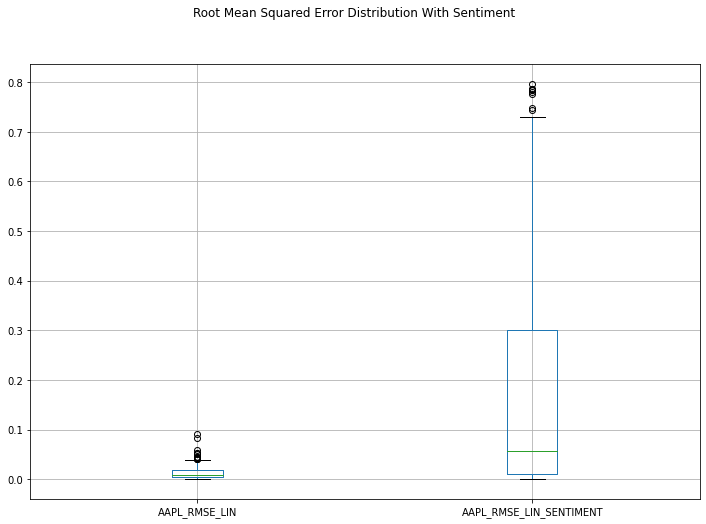

In [24]:
boxplot = AAPL_linear.boxplot(column=['AAPL_RMSE_LIN', 'AAPL_RMSE_LIN_SENTIMENT'],figsize=(12,8))
[ax_tmp.set_xlabel('') for ax_tmp in np.asarray(boxplot).reshape(-1)]
fig = np.asarray(boxplot).reshape(-1)[0].get_figure()
fig.suptitle('Root Mean Squared Error Distribution With Sentiment')

In [25]:
AAPL_linear_RMSE = AAPL_linear[['AAPL_RMSE_LIN', 'AAPL_RMSE_LIN_SENTIMENT']]
AAPL_linear_RMSE.describe()

,AAPL_RMSE_LIN,AAPL_RMSE_LIN_SENTIMENT
count,258.000000,258.000000
mean,0.013394,0.180875
std,0.013536,0.210544
min,0.000008,0.000186
25%,0.004417,0.009780
50%,0.009139,0.056273
75%,0.018377,0.300534
max,0.090848,0.796644


In [26]:
AAPL_linear_RMSE.to_csv('AAPL_Linear_Subs_Results.csv')